Simple training with efficientnet and pytorch_lightening

Highlights:
- easy to use pytorch_lightening module
- focal loss
- public score 0.8123

# Setup

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pylab import plt

import io
import itertools
from copy import deepcopy
import sys, os
from pathlib import Path
from PIL import Image

# %matplotlib notebook

train_path = Path('/kaggle/input/cassava-leaf-disease-classification/train_images')
test_path = Path('/kaggle/input/cassava-leaf-disease-classification/test_images')
labels_path = Path('/kaggle/input/cassava-leaf-disease-classification/train.csv')
train_df = pd.read_csv(labels_path)

In [1]:
import big_transfer

### Confusion matrix code:

In [3]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def get_confusion_matrix(data, N, normalized=True):
    confusion_matrix = np.zeros((N, N), dtype = np.int)

    for entry in data:
        for yi, yhi in zip(entry['y'], entry['y_hat']):
            confusion_matrix[int(yi), int(yhi)] += 1
    if normalized:
        confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
    return confusion_matrix

def plot_confusion_matrix(cm):
    """
    based on https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    plt.close('all')
    figure = plt.figure(figsize=(6, 6))
    if np.max(cm) <= 1:
        vmin, vmax = 0, 1
    else:
        vmin, vmax = 0, np.max(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=vmin, vmax=vmax);
    plt.title("Confusion matrix")
    plt.colorbar()

    # Round the confusion matrix.
    cm = np.around(cm, decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()

    return figure

### Focal loss code:

In [4]:
"""from https://github.com/kornia/kornia"""
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

def one_hot(labels: torch.Tensor,
            num_classes: int,
            device: Optional[torch.device] = None,
            dtype: Optional[torch.dtype] = None,
            eps: float = 1e-6) -> torch.Tensor:
    r"""Converts an integer label x-D tensor to a one-hot (x+1)-D tensor.
    Args:
        labels (torch.Tensor) : tensor with labels of shape :math:`(N, *)`,
                                where N is batch size. Each value is an integer
                                representing correct classification.
        num_classes (int): number of classes in labels.
        device (Optional[torch.device]): the desired device of returned tensor.
         Default: if None, uses the current device for the default tensor type
         (see torch.set_default_tensor_type()). device will be the CPU for CPU
         tensor types and the current CUDA device for CUDA tensor types.
        dtype (Optional[torch.dtype]): the desired data type of returned
         tensor. Default: if None, infers data type from values.
    Returns:
        torch.Tensor: the labels in one hot tensor of shape :math:`(N, C, *)`,
    Examples:
        >>> labels = torch.LongTensor([[[0, 1], [2, 0]]])
        >>> one_hot(labels, num_classes=3)
        tensor([[[[1.0000e+00, 1.0000e-06],
                  [1.0000e-06, 1.0000e+00]],
        <BLANKLINE>
                 [[1.0000e-06, 1.0000e+00],
                  [1.0000e-06, 1.0000e-06]],
        <BLANKLINE>
                 [[1.0000e-06, 1.0000e-06],
                  [1.0000e+00, 1.0000e-06]]]])
    """
    if not isinstance(labels, torch.Tensor):
        raise TypeError("Input labels type is not a torch.Tensor. Got {}"
                        .format(type(labels)))

    if not labels.dtype == torch.int64:
        raise ValueError(
            "labels must be of the same dtype torch.int64. Got: {}" .format(
                labels.dtype))

    if num_classes < 1:
        raise ValueError("The number of classes must be bigger than one."
                         " Got: {}".format(num_classes))

    shape = labels.shape
    one_hot = torch.zeros(
        (shape[0], num_classes) + shape[1:], device=device, dtype=dtype
    )

    return one_hot.scatter_(1, labels.unsqueeze(1), 1.0) + eps

def focal_loss(
        input: torch.Tensor,
        target: torch.Tensor,
        alpha: float,
        gamma: float = 2.0,
        reduction: str = 'none',
        eps: float = 1e-8) -> torch.Tensor:
    r"""Criterion that computes Focal loss.
    According to :cite:`lin2018focal`, the Focal loss is computed as follows:
    .. math::
        \text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)
    Where:
       - :math:`p_t` is the model's estimated probability for each class.
    Args:
        input (torch.Tensor): logits tensor with shape :math:`(N, C, *)` where C = number of classes.
        target (torch.Tensor): labels tensor with shape :math:`(N, *)` where each value is :math:`0 ≤ targets[i] ≤ C−1`.
        alpha (float): Weighting factor :math:`\alpha \in [0, 1]`.
        gamma (float, optional): Focusing parameter :math:`\gamma >= 0`. Default 2.
        reduction (str, optional): Specifies the reduction to apply to the
         output: ‘none’ | ‘mean’ | ‘sum’. ‘none’: no reduction will be applied,
         ‘mean’: the sum of the output will be divided by the number of elements
         in the output, ‘sum’: the output will be summed. Default: ‘none’.
        eps (float, optional): Scalar to enforce numerical stabiliy. Default: 1e-8.
    Return:
        torch.Tensor: the computed loss.
    Example:
        >>> N = 5  # num_classes
        >>> input = torch.randn(1, N, 3, 5, requires_grad=True)
        >>> target = torch.empty(1, 3, 5, dtype=torch.long).random_(N)
        >>> output = focal_loss(input, target, alpha=0.5, gamma=2.0, reduction='mean')
        >>> output.backward()
    """
    if not isinstance(input, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))

    if not len(input.shape) >= 2:
        raise ValueError("Invalid input shape, we expect BxCx*. Got: {}"
                         .format(input.shape))

    if input.size(0) != target.size(0):
        raise ValueError('Expected input batch_size ({}) to match target batch_size ({}).'
                         .format(input.size(0), target.size(0)))

    n = input.size(0)
    out_size = (n,) + input.size()[2:]
    if target.size()[1:] != input.size()[2:]:
        raise ValueError('Expected target size {}, got {}'.format(
            out_size, target.size()))

    if not input.device == target.device:
        raise ValueError(
            "input and target must be in the same device. Got: {} and {}" .format(
                input.device, target.device))

    # compute softmax over the classes axis
    input_soft: torch.Tensor = F.softmax(input, dim=1) + eps

    # create the labels one hot tensor
    target_one_hot: torch.Tensor = one_hot(
        target, num_classes=input.shape[1],
        device=input.device, dtype=input.dtype)

    # compute the actual focal loss
    weight = torch.pow(-input_soft + 1., gamma)

    focal = -alpha * weight * torch.log(input_soft)
    loss_tmp = torch.sum(target_one_hot * focal, dim=1)

    if reduction == 'none':
        loss = loss_tmp
    elif reduction == 'mean':
        loss = torch.mean(loss_tmp)
    elif reduction == 'sum':
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError("Invalid reduction mode: {}"
                                  .format(reduction))
    return loss


class FocalLoss(nn.Module):
    r"""Criterion that computes Focal loss.
    According to :cite:`lin2018focal`, the Focal loss is computed as follows:
    .. math::
        \text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)
    Where:
       - :math:`p_t` is the model's estimated probability for each class.
    Args:
        alpha (float): Weighting factor :math:`\alpha \in [0, 1]`.
        gamma (float, optional): Focusing parameter :math:`\gamma >= 0`. Default 2.
        reduction (str, optional): Specifies the reduction to apply to the
         output: ‘none’ | ‘mean’ | ‘sum’. ‘none’: no reduction will be applied,
         ‘mean’: the sum of the output will be divided by the number of elements
         in the output, ‘sum’: the output will be summed. Default: ‘none’.
        eps (float, optional): Scalar to enforce numerical stabiliy. Default: 1e-8.
    Shape:
        - Input: :math:`(N, C, *)` where C = number of classes.
        - Target: :math:`(N, *)` where each value is
          :math:`0 ≤ targets[i] ≤ C−1`.
    Example:
        >>> N = 5  # num_classes
        >>> kwargs = {"alpha": 0.5, "gamma": 2.0, "reduction": 'mean'}
        >>> criterion = FocalLoss(**kwargs)
        >>> input = torch.randn(1, N, 3, 5, requires_grad=True)
        >>> target = torch.empty(1, 3, 5, dtype=torch.long).random_(N)
        >>> output = criterion(input, target)
        >>> output.backward()
    """

    def __init__(self, alpha: float, gamma: float = 2.0,
                 reduction: str = 'none', eps: float = 1e-8) -> None:
        super(FocalLoss, self).__init__()
        self.alpha: float = alpha
        self.gamma: float = gamma
        self.reduction: str = reduction
        self.eps: float = eps

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return focal_loss(input, target, self.alpha, self.gamma, self.reduction, self.eps)


def binary_focal_loss_with_logits(
        input: torch.Tensor,
        target: torch.Tensor,
        alpha: float = .25,
        gamma: float = 2.0,
        reduction: str = 'none',
        eps: float = 1e-8) -> torch.Tensor:
    r"""Function that computes Binary Focal loss.
    .. math::
        \text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)
    where:
       - :math:`p_t` is the model's estimated probability for each class.
    Args:
        input (torch.Tensor): input data tensor with shape :math:`(N, 1, *)`.
        target (torch.Tensor): the target tensor with shape :math:`(N, 1, *)`.
        alpha (float): Weighting factor for the rare class :math:`\alpha \in [0, 1]`. Default: 0.25.
        gamma (float): Focusing parameter :math:`\gamma >= 0`. Default: 2.0.
        reduction (str, optional): Specifies the reduction to apply to the. Default: 'none'.
        eps (float): for numerically stability when dividing. Default: 1e-8.
    Returns:
        torch.tensor: the computed loss.
    Examples:
        >>> num_classes = 1
        >>> kwargs = {"alpha": 0.25, "gamma": 2.0, "reduction": 'mean'}
        >>> logits = torch.tensor([[[[6.325]]],[[[5.26]]],[[[87.49]]]])
        >>> labels = torch.tensor([[[1.]],[[1.]],[[0.]]])
        >>> binary_focal_loss_with_logits(logits, labels, **kwargs)
        tensor(4.6052)
    """

    if not isinstance(input, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))

    if not len(input.shape) >= 2:
        raise ValueError("Invalid input shape, we expect BxCx*. Got: {}"
                         .format(input.shape))

    if input.size(0) != target.size(0):
        raise ValueError('Expected input batch_size ({}) to match target batch_size ({}).'
                         .format(input.size(0), target.size(0)))

    probs = torch.sigmoid(input)
    target = target.unsqueeze(dim=1)
    loss_tmp = -alpha * torch.pow((1. - probs), gamma) * target * torch.log(probs + eps) \
               - (1 - alpha) * torch.pow(probs, gamma) * (1. - target) * torch.log(1. - probs + eps)
    loss_tmp = loss_tmp.squeeze(dim=1)

    if reduction == 'none':
        loss = loss_tmp
    elif reduction == 'mean':
        loss = torch.mean(loss_tmp)
    elif reduction == 'sum':
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError("Invalid reduction mode: {}"
                                  .format(reduction))
    return loss


class BinaryFocalLossWithLogits(nn.Module):
    r"""Criterion that computes Focal loss.
    According to :cite:`lin2017focal`, the Focal loss is computed as follows:
    .. math::
        \text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)
    where:
       - :math:`p_t` is the model's estimated probability for each class.
    Args:
        alpha (float): Weighting factor for the rare class :math:`\alpha \in [0, 1]`.
        gamma (float): Focusing parameter :math:`\gamma >= 0`.
        reduction (str, optional): Specifies the reduction to apply to the
         output: ‘none’ | ‘mean’ | ‘sum’. ‘none’: no reduction will be applied,
         ‘mean’: the sum of the output will be divided by the number of elements
         in the output, ‘sum’: the output will be summed. Default: ‘none’.
    Shape:
        - Input: :math:`(N, 1, *)`.
        - Target: :math:`(N, 1, *)`.
    Examples:
        >>> N = 1  # num_classes
        >>> kwargs = {"alpha": 0.25, "gamma": 2.0, "reduction": 'mean'}
        >>> loss = BinaryFocalLossWithLogits(**kwargs)
        >>> input = torch.randn(1, N, 3, 5, requires_grad=True)
        >>> target = torch.empty(1, 3, 5, dtype=torch.long).random_(N)
        >>> output = loss(input, target)
        >>> output.backward()
    """

    def __init__(self, alpha: float, gamma: float = 2.0,
                 reduction: str = 'none') -> None:
        super(BinaryFocalLossWithLogits, self).__init__()
        self.alpha: float = alpha
        self.gamma: float = gamma
        self.reduction: str = reduction
        self.eps: float = 1e-8

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return binary_focal_loss_with_logits(
            input, target, self.alpha, self.gamma, self.reduction, self.eps)

In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl

# Config

In [6]:
N_classes = 5
bit_model_version = 'M-R50x1'
crop_size = 512 #512
net_input_size = 256

# Data preparation

In [7]:
train_transforms = transforms.Compose([
#             transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomCrop((crop_size,crop_size)),
            transforms.Resize((net_input_size, net_input_size)),
#             transforms.ColorJitter(brightness=0.2, contrast=0.15, saturation=0.1),
            transforms.RandomHorizontalFlip()])

val_transforms = transforms.Compose([
#             transforms.RandomCrop((crop_size,crop_size)),
            transforms.Resize((net_input_size, net_input_size))])

test_transforms = val_transforms

## Dataset class

In [8]:
class Cassava(torch.utils.data.Dataset):

    def __init__(self,
                 img_dir,
                 df,
                 img_transforms = None,
                 tensor_transforms = None, #transforms applied on Tensor
                 output_tensor = True): #if False: image is returned
        self.df = df
        self.img_dir = Path(img_dir)
        self.img_transforms = img_transforms
        self.tensor_transforms = tensor_transforms
        self.output_tensor = output_tensor
        
        self.classes = sorted(self.df.label.unique())

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_fn, label = self.df.iloc[idx]
        
        img = Image.open(self.img_dir / img_fn)
        
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        
        if self.output_tensor:
            img = transforms.functional.to_tensor(img)
            if self.tensor_transforms is not None:
                img = self.tensor_transforms(img)
        return img, label

## Utility functions

In [9]:
def accuracy(y_hat, y):
    result = torch.mean((y_hat.detach() == y.detach()).float())
    return result

In [10]:
def log_figure(logger, fig, image_label='confusion matrix', epoch=0):
    """https://stackoverflow.com/questions/57316491/how-to-convert-matplotlib-figure-to-pil-image-object-without-saving-image"""
#     pil_image = Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi = 300)
    buf.seek(0)
    pil_img = deepcopy(Image.open(buf))
    buf.close()
    
    img = transforms.functional.to_tensor(pil_img)
    logger.experiment.add_image(image_label, img, epoch)


## Data setup

In [11]:
ds = Cassava(train_path, train_df)

In [12]:
N = len(train_df)
val_size = int(0.1 * N)
mask_val = np.zeros(N, dtype='bool')
mask_val[np.random.choice(np.arange(N), val_size, replace=False)] = True
ds_train = Cassava(train_path, train_df.loc[~mask_val], img_transforms=train_transforms)
ds_val = Cassava(train_path, train_df.loc[mask_val], img_transforms=val_transforms)

In [13]:
ds_val.img_transforms = val_transforms
ds_train.img_transforms = train_transforms

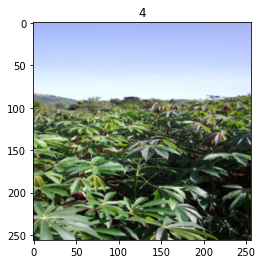

In [14]:
ds_train.output_tensor = False
img, label = ds_train[np.random.randint(len(ds_train))]
plt.imshow(img)
plt.title(label)
ds_train.output_tensor = True

## PL Module

In [15]:
class MyModel(pl.LightningModule):

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.batch_size = None

    def forward(self, x):
        y = self.model(x)
        return y
    
    def training_setup(self, loss_fn=None, train_dataset=None, val_dataset=None,
                      batch_size=None, lr=1e-3):
        if loss_fn is not None:
            self.loss_fn = loss_fn
        if train_dataset is not None:
            self.train_dataset = train_dataset
        if val_dataset is not None:
            self.val_dataset = val_dataset
        if batch_size is not None:
            self.batch_size = batch_size
        if lr is not None:
            self.lr = lr            
            
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        p = self.model(x)
        loss = self.loss_fn(p, y)
        
        y_hat = torch.argmax(p.detach(), dim=1)
#         # Logging to TensorBoard by default
# pytorch-lightning 0.10
        self.log('train_loss', loss)
        self.log('train_accuracy', accuracy(y_hat, y))
        return {'loss': loss, 'y_hat': y_hat.detach().cpu().numpy(), 'y': y.detach().cpu().numpy()}

    def validation_step(self, batch, batch_idx):
        return self._shared_eval(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self._shared_eval(batch, batch_idx, 'test')

    def _shared_eval(self, batch, batch_idx, prefix):
        x, y = batch
        p = self.model(x)
        loss = self.loss_fn(p, y)
        y_hat = torch.argmax(p.detach(), dim=1)

         # Logging to TensorBoard by default
        self.log_dict({f'{prefix}_loss': loss, f'{prefix}_accuracy': accuracy(y_hat, y)})
        return {'loss': loss, 'y_hat': y_hat.detach().cpu().numpy(), 'y': y.detach().cpu().numpy()}        

    def log_confusion_matrix(self, data, prefix, normalized=True):
        confusion_matrix = get_confusion_matrix(data, N_classes, normalized=normalized)
        confusion_matrix_fig = plot_confusion_matrix(confusion_matrix)
        log_figure(self.logger, confusion_matrix_fig, f'{prefix}_confusion matrix', epoch=self.current_epoch)        
    
    def training_epoch_end(self, training_step_outputs):
        self.log_confusion_matrix(training_step_outputs, 'train')
    
    def validation_epoch_end(self, validation_step_outputs):
        self.log_confusion_matrix(validation_step_outputs, 'val')
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [scheduler]
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0)


## Model setup

In [16]:
net = big_transfer.get_pretrained_model(N_classes, bit_model_version)

In [17]:
mymodel = MyModel(net)
mymodel.training_setup(loss_fn=FocalLoss(alpha=0.5, reduction='mean')) #torch.nn.CrossEntropyLoss())
mymodel.training_setup(train_dataset=ds_train, val_dataset=ds_val)
mymodel.training_setup(batch_size=8)

In [18]:
# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
# trainer = pl.Trainer(gpus=8) (if you have GPUs)
early_stopping_callback = pl.callbacks.EarlyStopping('val_loss', patience=5)
trainer = pl.Trainer(callbacks=[early_stopping_callback],
                     accumulate_grad_batches=4,
#                       gradient_clip_val=0.5,
                     max_epochs=200,
#                      val_check_interval=0.25, #check_val_every_n_epoch=1
                     gpus=1, auto_select_gpus=True #,
#                      tpu_cores=[1]
#                      auto_scale_batch_size='binsearch'
                    ) # needs data loader in pl_module
# trainer = Trainer(default_root_dir='/your/path/to/save/checkpoints')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [19]:
# trainer.tune(mymodel)

# Training


  | Name    | Type      | Params
--------------------------------------
0 | model   | ResNetV2  | 42.5 M
1 | loss_fn | FocalLoss | 0     


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


1

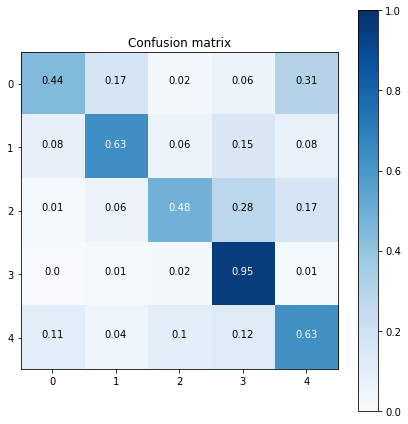

In [20]:
trainer.fit(mymodel)

# Test

In [21]:
test_files = list(test_path.glob('*.jpg'))
train_files = list(train_path.glob('*.jpg'))

In [22]:
class CassavaTest(torch.utils.data.Dataset):
    def __init__(self, list_of_files, transforms=None):
        self.list_of_files = list_of_files
        self.transforms = transforms
    def __len__(self):
        return len(self.list_of_files)
    def __getitem__(self, idx):
        fn = self.list_of_files[idx]
        x = Image.open(fn)
        if self.transforms is not None:
            for transform in self.transforms:
                x = transform(x)
        return x, idx

In [23]:
test_dataset = CassavaTest(test_files, [test_transforms, transforms.ToTensor()]) #train_files[:22]
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

In [24]:
test_dataset[0]

(tensor([[[0.5490, 0.6196, 0.6549,  ..., 0.5294, 0.5804, 0.5020],
          [0.6118, 0.6510, 0.7216,  ..., 0.6275, 0.6157, 0.6588],
          [0.7412, 0.7451, 0.8196,  ..., 0.6118, 0.5333, 0.6706],
          ...,
          [0.1059, 0.0980, 0.1020,  ..., 0.1255, 0.1294, 0.1529],
          [0.1333, 0.1294, 0.1294,  ..., 0.0980, 0.1137, 0.1255],
          [0.0941, 0.1098, 0.1216,  ..., 0.0824, 0.0745, 0.0863]],
 
         [[0.5569, 0.6863, 0.7255,  ..., 0.6745, 0.7216, 0.6039],
          [0.6353, 0.7216, 0.7843,  ..., 0.7294, 0.7176, 0.7294],
          [0.7804, 0.8118, 0.8549,  ..., 0.6863, 0.6157, 0.7373],
          ...,
          [0.1725, 0.1725, 0.1765,  ..., 0.1020, 0.1059, 0.1294],
          [0.2039, 0.2039, 0.2039,  ..., 0.0667, 0.0824, 0.0941],
          [0.1725, 0.1882, 0.1961,  ..., 0.0471, 0.0392, 0.0510]],
 
         [[0.4667, 0.5804, 0.6353,  ..., 0.4824, 0.4392, 0.4078],
          [0.5922, 0.6588, 0.7255,  ..., 0.5569, 0.4706, 0.5569],
          [0.7882, 0.8039, 0.8471,  ...,

In [25]:
def predict(model, dataloader):
    result = {'idx': [], 'label': []}
    for x, idxs in dataloader:
        p = model(x)
        y_hat = torch.argmax(p.detach(), dim=1)
        result['idx'].extend(list(idxs.detach().cpu().long().numpy()))
        result['label'].extend(list(y_hat.cpu().numpy()))
    return result

In [26]:
test_result = predict(mymodel, test_dataloader)

In [27]:
test_result['image_id'] = [test_dataset.list_of_files[n].name for n in test_result['idx']]

In [28]:
final_result = pd.DataFrame({'image_id': test_result['image_id'], 'label': test_result['label']})

In [29]:
final_result.to_csv('submission.csv', index=False)